<p align= " center"> <strong>MORAN'S INDEX</p>
<p><b>By: Jefferson C.</b></p>

---

### __GLOBAL MORAN'S INDEX__

In [3]:
# DEPENDENCIES 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
    # Import data (shp)
import geopandas as gpd
    # Weight Matrix
from libpysal.weights import Queen, Rook, W, lag_spatial, w_subset
    # Global index (MORAN'S)
from esda.moran import Moran
    # Warnings
import warnings
import contextlib

def global_moran(
    gdf,
    fields,
    contiguities=("queen", "rook", "bishop"),
    permutations=9999,
    alpha=0.05,
    drop_islands=True,
    standardize_x=True,
    use_index=True,
    style="seaborn-v0_8",
    silence_warnings=True,
    dashboard_field=None,
    figsize=(15, 10),
):
    """
    GLOBAL Moran's I for multiple variables and spatial contiguities
    (Queen / Rook / Bishop).

    Assumptions:
      - gdf is already CLEAN (numeric fields, no NaN/inf values)
      - geometries are valid

    Returns:
      1) results_table : long-format table with Global Moran results
      2) fig           : dashboard (scatterplot + permutation histogram)
      3) out           : dictionary with internal objects
    """

    # BASIC INPUT HANDLING
    if isinstance(fields, str):
        fields = [fields]
    fields = list(fields)

    contiguities = tuple(c.lower().strip() for c in contiguities)
    allowed = {"queen", "rook", "bishop"}
    if any(c not in allowed for c in contiguities):
        raise ValueError(f"contiguities must be in {allowed}")

    # Default dashboard variable
    if dashboard_field is None:
        dashboard_field = fields[0]
    if dashboard_field not in fields:
        raise ValueError("dashboard_field must be inside fields")

    # Warning about index handling (important for islands removal)
    if not use_index:
        warnings.warn(
            "use_index=False may misalign island IDs with gdf.index "
            "when dropping islands. Recommended: use_index=True.",
            UserWarning,
        )

    # CONTEXT MANAGERS (avoid global side effects)
    @contextlib.contextmanager
    def _maybe_style(style_name):
        """
        Temporarily apply a matplotlib style without
        contaminating global rcParams.
        """
        old = plt.rcParams.copy()
        try:
            plt.style.use(style_name)
            yield
        finally:
            plt.rcParams.update(old)

    @contextlib.contextmanager
    def _maybe_warnings(silence):
        """
        Optionally silence common PySAL warnings related
        to disconnected weight matrices and index usage.
        """
        if not silence:
            yield
            return
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                category=UserWarning,
                message=".*weights matrix is not fully connected.*",
            )
            warnings.filterwarnings(
                "ignore",
                category=FutureWarning,
                message=".*use_index.*",
            )
            yield

    # HELPER FUNCTIONS
    def _zscore(x):
        """
        Z-score standardization using population standard deviation (ddof=0).
        If variance is zero, returns a zero vector to avoid numerical issues.
        """
        sd = x.std(ddof=0)
        return (x - x.mean()) / sd if sd > 0 else x * 0.0

    def _build_weights(df):
        """
        Build spatial weight matrices for all requested contiguities:
          - Queen  : shared edge or vertex
          - Rook   : shared edge
          - Bishop : shared vertex only (Queen - Rook)
        """
        wq = Queen.from_dataframe(df, use_index=use_index)
        wr = Rook.from_dataframe(df, use_index=use_index)

        out = {}
        if "queen" in contiguities:
            out["queen"] = wq
        if "rook" in contiguities:
            out["rook"] = wr
        if "bishop" in contiguities:
            ids = list(wq.id_order)
            neighbors = {
                i: list(set(wq.neighbors.get(i, [])) - set(wr.neighbors.get(i, [])))
                for i in ids
            }
            out["bishop"] = W(neighbors, id_order=ids)

        return out

    def _subset_drop_islands(w, df):
        """
        Subset a spatial weights object to match the dataframe
        and optionally remove islands (units with no neighbors).
        """
        ids = list(df.index) if use_index else list(range(len(df)))
        w2 = w_subset(w, ids)

        islands_initial = list(getattr(w2, "islands", []))

        if drop_islands and islands_initial:
            df2 = df.drop(index=islands_initial).copy() if use_index else df.copy()
            ids2 = list(df2.index) if use_index else list(range(len(df2)))
            w2 = w_subset(w, ids2)
            return w2, df2, islands_initial

        return w2, df, islands_initial

    # RESULTS TABLE
    rows = []

    with _maybe_warnings(silence_warnings), _maybe_style(style):

        # Build full weight matrices ONCE
        w_full = _build_weights(gdf)

        # Loop over variables and contiguities
        for field in fields:
            for c in contiguities:

                # Subset weights and optionally drop islands
                w2, df2, islands_initial = _subset_drop_islands(w_full[c], gdf)
                w2.transform = "R"  # row-standardized weights (GeoDa style)

                x = df2[field].to_numpy()
                var_x = float(np.var(x, ddof=0))

                # Degenerate cases: too few observations or zero variance
                if len(x) < 3 or np.std(x, ddof=0) == 0:
                    rows.append(dict(
                        variable=field,
                        contiguity=c.upper(),
                        n=int(len(x)),
                        var_x=var_x,
                        Moran_I=np.nan,
                        E_I=float(-1 / (len(x) - 1)) if len(x) > 1 else np.nan,
                        z_sim=np.nan,
                        p_value_perm=np.nan,
                        significant_alpha=False,
                        permutations=int(permutations),
                        islands_initial=int(len(islands_initial)),
                        islands_removed=int(len(islands_initial)) if drop_islands else 0,
                        islands_remaining=int(len(getattr(w2, "islands", []))),
                        note="n<3 or zero variance",
                    ))
                    continue

                # Global Moran computation
                mi = Moran(x, w2, permutations=permutations)

                rows.append(dict(
                    variable=field,
                    contiguity=c.upper(),
                    n=int(len(x)),
                    var_x=var_x,
                    Moran_I=float(mi.I),
                    E_I=float(mi.EI),
                    z_sim=float(mi.z_sim),
                    p_value_perm=float(mi.p_sim),
                    significant_alpha=bool(mi.p_sim < alpha),
                    permutations=int(permutations),
                    islands_initial=int(len(islands_initial)),
                    islands_removed=int(len(islands_initial)) if drop_islands else 0,
                    islands_remaining=int(len(getattr(w2, "islands", []))),
                    note="",
                ))

        # Build results table
        results_table = pd.DataFrame(rows)

        order = pd.CategoricalDtype(["QUEEN", "ROOK", "BISHOP"], ordered=True)
        results_table["contiguity"] = (
            results_table["contiguity"].astype(str).str.upper().astype(order)
        )
        results_table = (
            results_table.sort_values(["variable", "contiguity"])
            .reset_index(drop=True)
        )

        # DASHBOARD (single variable visualization)
        dash = {}
        kinds = list(contiguities)

        for kind in kinds:
            w2, df2, _ = _subset_drop_islands(w_full[kind], gdf)
            w2.transform = "R"

            x = df2[dashboard_field].to_numpy()
            mi = Moran(x, w2, permutations=permutations)

            x_plot = _zscore(x) if standardize_x else x.copy()
            wx_plot = lag_spatial(w2, x_plot)

            dash[kind] = dict(
                gdf=df2,
                w=w2,
                x=x,
                mi=mi,
                x_plot=x_plot,
                wx_plot=wx_plot,
            )

        # PLOTS
        fig, axes = plt.subplots(len(kinds), 2, figsize=figsize)
        if len(kinds) == 1:
            axes = np.array([axes])

        for r, kind in enumerate(kinds):
            mi = dash[kind]["mi"]
            x_plot = dash[kind]["x_plot"]
            wx_plot = dash[kind]["wx_plot"]

            # Moran scatterplot
            ax_sc = axes[r, 0]
            ax_sc.scatter(x_plot, wx_plot, edgecolor="darkblue", facecolor="none")
            ax_sc.axhline(0, color="black", linestyle="--", linewidth=1)
            ax_sc.axvline(0, color="black", linestyle="--", linewidth=1)

            xx = np.linspace(np.min(x_plot), np.max(x_plot), 100)
            ax_sc.plot(xx, mi.I * xx, linewidth=2,color ="darkred")
            
            ax_sc.set_title(
                f"{kind.upper()} — Moran Scatterplot (I={mi.I:.3f})",
                fontweight="bold",
            )
            ax_sc.set_xlabel(
                f"{dashboard_field} ({'std' if standardize_x else 'raw'})"
            )
            ax_sc.set_ylabel("Spatial lag")

            # Permutation histogram
            ax_ph = axes[r, 1]
            ax_ph.hist(mi.sim, bins=30, edgecolor="darkblue")
            ax_ph.axvline(mi.I, linewidth=2,color ="darkred")
            ax_ph.set_title(
                f"{kind.upper()} — Permutations (p={mi.p_sim:.4f})",
                fontweight="bold",
            )
            ax_ph.set_xlabel("Moran's I")
            ax_ph.set_ylabel("Frequency")

        fig.suptitle(
            f"GLOBAL MORAN'S I — {dashboard_field}",
            y=1.02,
            fontsize=14,
            fontweight="bold",
        )
        fig.tight_layout()

    out = {"dashboard": dash, "results_table": results_table}
    return results_table, fig, out

In [4]:
import geopandas as gpd
gdf = gpd.read_file("NY-House-Dataset/NY-House-SHP/VORONOI.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   PRICE       4200 non-null   int64   
 1   BEDS        4200 non-null   int64   
 2   BATH        4200 non-null   float64 
 3   PROPERTYSQ  4200 non-null   float64 
 4   LATITUDE    4200 non-null   float64 
 5   LONGITUDE   4200 non-null   float64 
 6   LOG-PRICE   4200 non-null   float64 
 7   LOG-PROPER  4200 non-null   float64 
 8   SUBLOCALIT  4200 non-null   object  
 9   TYPE        4200 non-null   object  
 10  BOROUGH     4200 non-null   object  
 11  TYPE-GROUP  4200 non-null   object  
 12  RESIDUALS   4200 non-null   float64 
 13  Y-HAT       4200 non-null   float64 
 14  geometry    4200 non-null   geometry
dtypes: float64(8), geometry(1), int64(2), object(4)
memory usage: 492.3+ KB


,variable,contiguity,n,var_x,Moran_I,E_I,z_sim,p_value_perm,significant_alpha,permutations,islands_initial,islands_removed,islands_remaining,note
0,BATH,QUEEN,4200,4.047413,0.085547,-0.000238,9.094129,0.001,True,999,0,0,0,
1,BATH,ROOK,4200,4.047413,0.085547,-0.000238,9.533532,0.001,True,999,0,0,0,
2,LOG-PRICE,QUEEN,4200,1.013401,0.394474,-0.000238,42.915675,0.001,True,999,0,0,0,
3,LOG-PRICE,ROOK,4200,1.013401,0.394474,-0.000238,44.674232,0.001,True,999,0,0,0,
4,LOG-PROPER,QUEEN,4200,0.346535,0.127911,-0.000238,14.577016,0.001,True,999,0,0,0,
5,LOG-PROPER,ROOK,4200,0.346535,0.127911,-0.000238,13.544446,0.001,True,999,0,0,0,


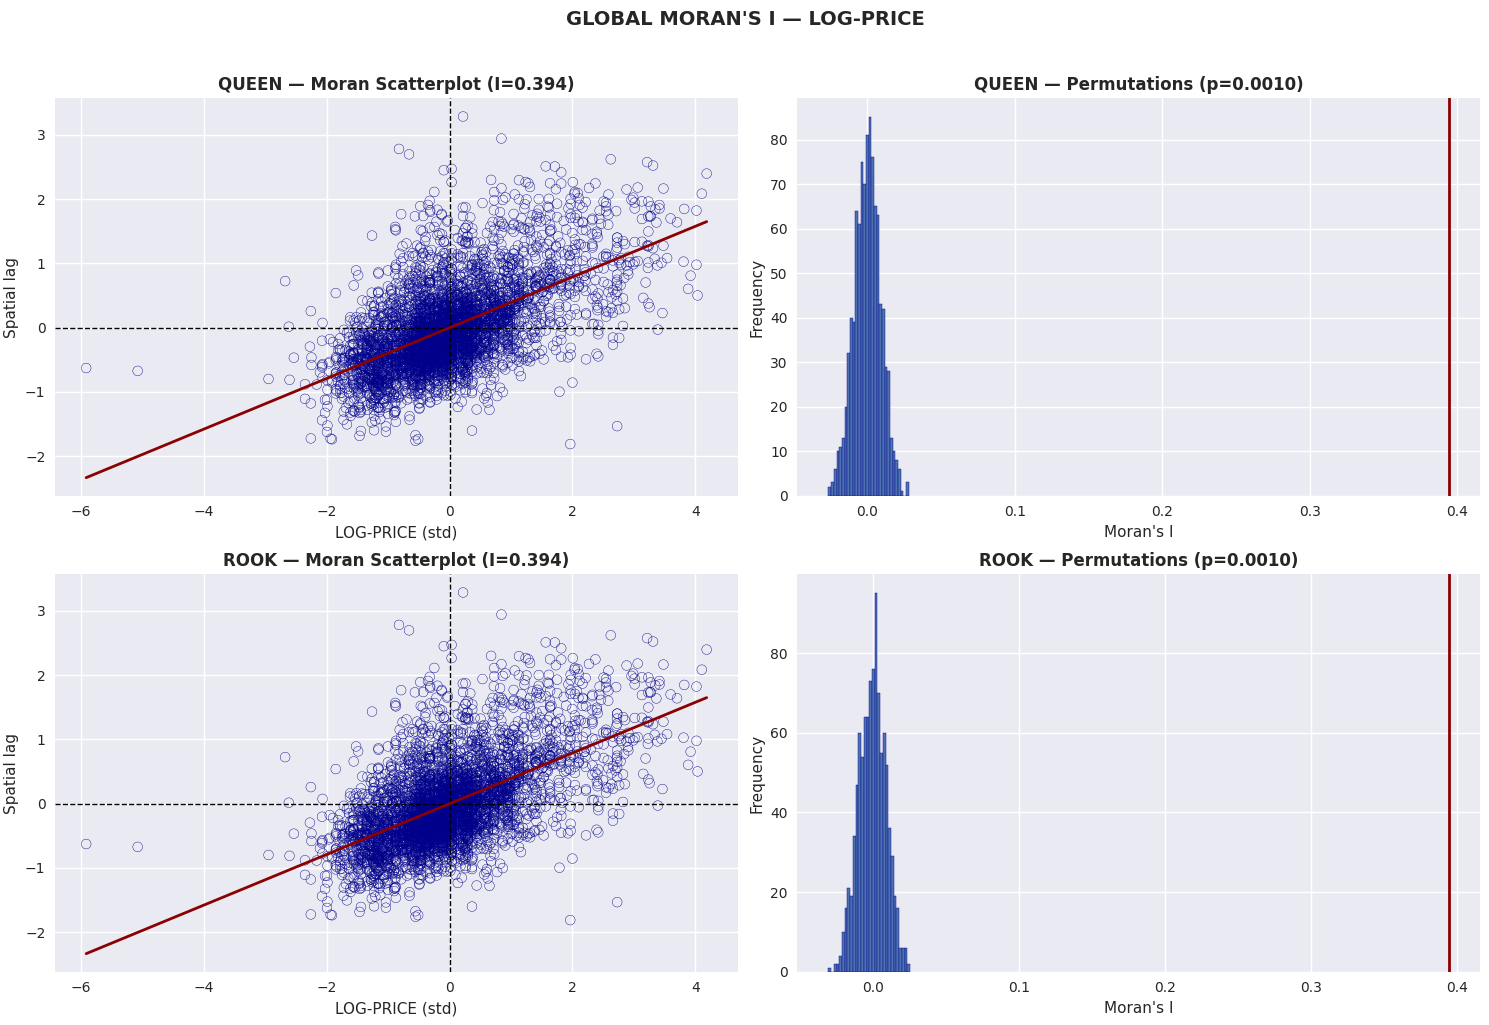

In [5]:
# Inputs 
fields = ["LOG-PRICE","LOG-PROPER","BATH"]

table, fig, out = global_moran(
    gdf,
    fields,
    permutations=999,
    contiguities=("queen", "rook"),
    alpha=0.05,
    dashboard_field="LOG-PRICE",
)

# Outputs
display(table)
plt.show()

In [17]:
# Inputs 
gdf = gpd.read_file("NY-House-Dataset/NY-House-SHP/VORONOI.shp")
ols_data = gpd.read_file('NY-House-Dataset/NY-House-SHP/VORONOI.shp')
sar_data = pd.read_csv('NY-House-Dataset/NY-House-SAR.csv').head(9)
gdf['RESIDUALS_OLS'] = ols_data['RESIDUALS']
sar_data.info()
gdf['RESIDUAL_SAR'] = sar_data['RESIDUALS_SAR']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PRICE          9 non-null      int64  
 1   BEDS           9 non-null      int64  
 2   BATH           9 non-null      float64
 3   PROPERTYSQ     9 non-null      float64
 4   LATITUDE       9 non-null      float64
 5   LONGITUDE      9 non-null      float64
 6   LOG-PRICE      9 non-null      float64
 7   LOG-PROPER     9 non-null      float64
 8   SUBLOCALIT     9 non-null      object 
 9   TYPE           9 non-null      object 
 10  BOROUGH        9 non-null      object 
 11  TYPE-GROUP     9 non-null      object 
 12  RESIDUALS      9 non-null      float64
 13  Y-HAT          9 non-null      float64
 14  geometry       9 non-null      object 
 15  RESIDUALS_SAR  9 non-null      float64
dtypes: float64(9), int64(2), object(5)
memory usage: 1.3+ KB


In [42]:
gdf['RESIDUAL_SAR'] = gdf['RESIDUAL_SAR'].dropna()
data_sar = gdf.head(8)

,variable,contiguity,n,var_x,Moran_I,E_I,z_sim,p_value_perm,significant_alpha,permutations,islands_initial,islands_removed,islands_remaining,note
0,RESIDUALS_OLS,QUEEN,8,0.054741,-0.354448,-0.142857,-0.942955,0.190,False,999,0,0,0,
1,RESIDUALS_OLS,ROOK,8,0.054741,-0.354448,-0.142857,-0.968957,0.176,False,999,0,0,0,
2,RESIDUAL_SAR,QUEEN,8,0.071698,-0.302736,-0.142857,-0.730872,0.238,False,999,0,0,0,
3,RESIDUAL_SAR,ROOK,8,0.071698,-0.302736,-0.142857,-0.693394,0.243,False,999,0,0,0,


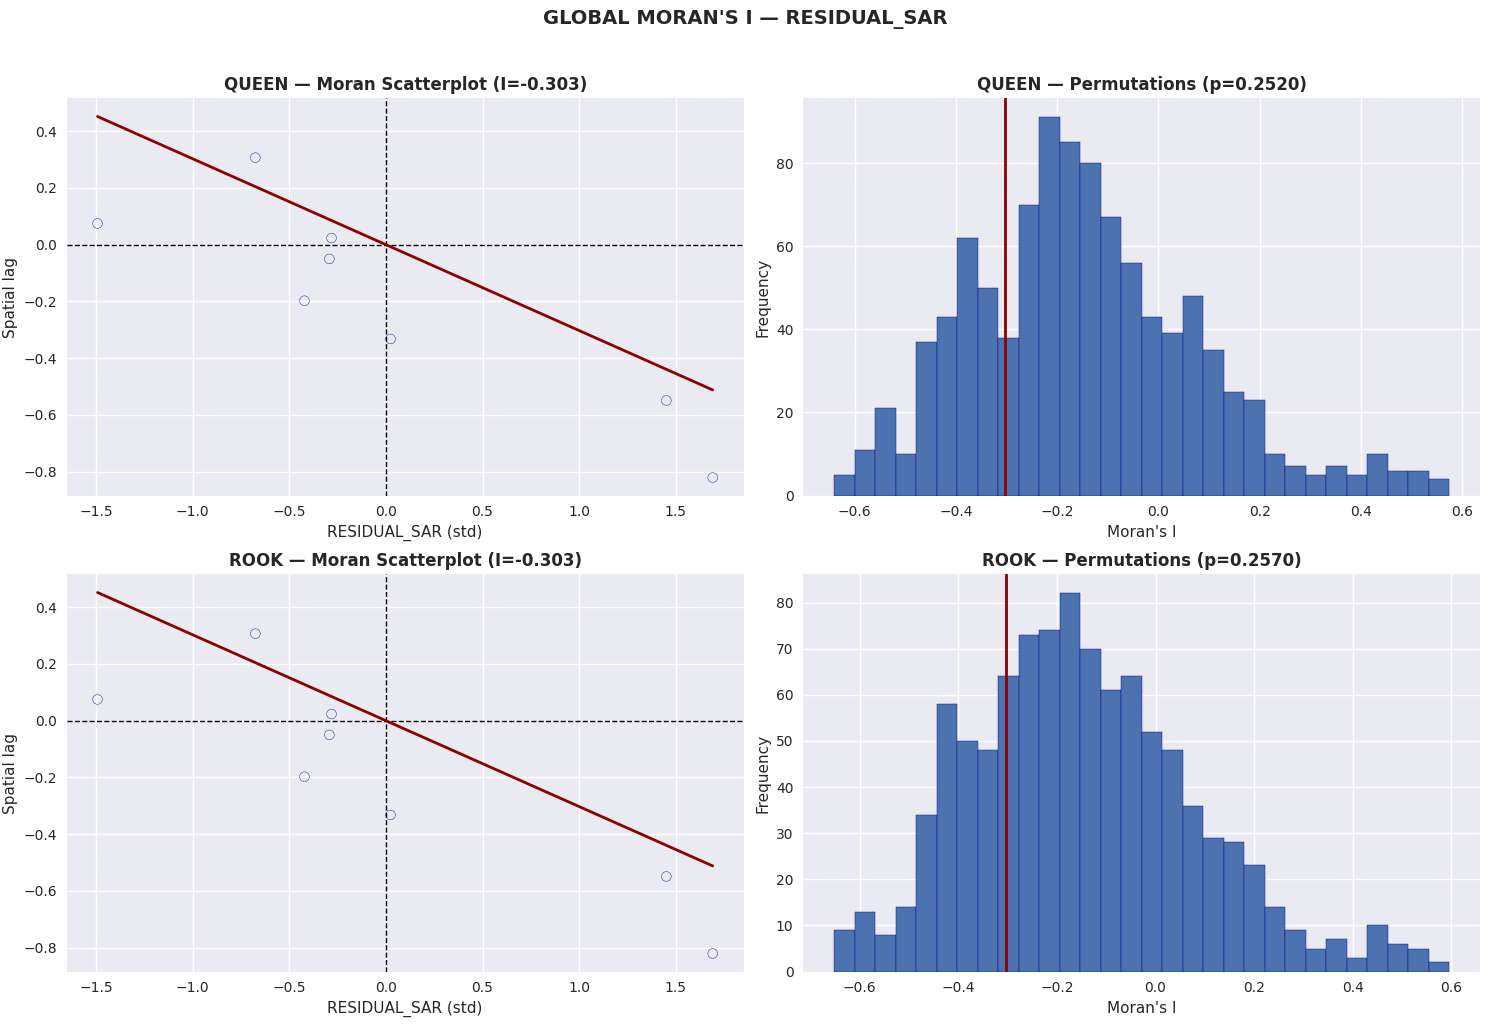

In [44]:
fields = ["RESIDUAL_SAR","RESIDUALS_OLS"]

table, fig, out = global_moran(
    data_sar,
    fields,
    permutations=999,
    contiguities=("queen", "rook"),
    alpha=0.05,
    dashboard_field="RESIDUAL_SAR",
)

# Outputs
display(table)
plt.show()

---

### __LOCAL MORAN'S INDEX__

In [ ]:
# DEPENDENCIES 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

    # Import data (shp)
import geopandas as gpd
    # Weight Matrix
from libpysal.weights import Queen, Rook, W, lag_spatial
    # Global index (MORAN'S)
from esda.moran import Moran, Moran_Local
    # Warnings
import warnings

def local_moran(
    gdf,
    fields,
    contiguities=("queen", "rook", "bishop"),
    permutations: int = 999,
    alpha: float = 0.05,
    drop_islands: bool = True,
    standardize_x: bool = True,
    use_index: bool = True,
    figsize=(18, 12),
    style: str = "seaborn-v0_8",
    silence_warnings: bool = True,
    dashboard_field: str | None = None,
):
    """
    Local Moran (LISA) for MULTIPLE variables and 3 contiguities (Queen/Rook/Bishop).

    Returns:
      - results_table: long table with Global Moran + LISA counts (per variable x contiguity)
      - fig: Dashboard for ONE variable (dashboard_field):
             (1) Moran scatter, (2) LISA significance map, (3) LISA cluster map
             repeated for each contiguity (rows)
      - out: dict with detailed objects for the dashboard_field

    Assumption:
      - gdf is already clean (numeric, no NaN/inf). If not, you can re-enable a numeric mask.
    """

    # BASIC INPUT HANDLING
    if isinstance(fields, str):
        fields = [fields]
    fields = list(fields)

    missing = [c for c in fields if c not in gdf.columns]
    if missing:
        raise ValueError(f"These fields are missing in gdf: {missing}")

    contiguities = tuple(c.lower().strip() for c in contiguities)
    allowed = {"queen", "rook", "bishop"}
    if any(c not in allowed for c in contiguities):
        raise ValueError(f"contiguities must be in {allowed}")

    # Default dashboard variable (the one that will be plotted)
    if dashboard_field is None:
        dashboard_field = fields[0]
    if dashboard_field not in fields:
        raise ValueError("dashboard_field must be inside fields")

    # Important note about islands alignment
    if not use_index:
        warnings.warn(
            "use_index=False may misalign island IDs with gdf.index when dropping islands. "
            "Recommended: use_index=True.",
            UserWarning,
        )

    # PLOT STYLE AND WARNING HANDLING 
    plt.style.use(style)

    if silence_warnings:
        warnings.filterwarnings(
            "ignore",
            category=UserWarning,
            message=".*weights matrix is not fully connected.*",
        )
        warnings.filterwarnings(
            "ignore",
            category=FutureWarning,
            message=".*use_index.*",
        )

    # HELPER: BUILD SPATIAL WEIGHTS
    def build_w(df, kind):
        """
        Build a spatial weights object for a given contiguity type:
          - queen  : shared edge OR vertex
          - rook   : shared edge
          - bishop : shared vertex only (queen minus rook)
        """
        if kind == "queen":
            return Queen.from_dataframe(df, use_index=use_index)

        if kind == "rook":
            return Rook.from_dataframe(df, use_index=use_index)

        if kind == "bishop":
            wq = Queen.from_dataframe(df, use_index=use_index)
            wr = Rook.from_dataframe(df, use_index=use_index)

            ids = list(wq.id_order)
            neighbors = {}
            for i in ids:
                nq = set(wq.neighbors.get(i, []))
                nr = set(wr.neighbors.get(i, []))
                neighbors[i] = list(nq - nr)  # vertex-only adjacency

            return W(neighbors, id_order=ids)

        raise ValueError("kind must be queen/rook/bishop")

    # HELPER: Z-SCORE STANDARIZATION FOR MORAN SCATTERPLOT
    def zscore(x):
        sd = x.std(ddof=0)
        return (x - x.mean()) / sd if sd > 0 else x * 0.0

    # PRECOMPUTE (BY CONTIGUITY) :  WEIGHTS + ISLAND HANDLING ONCE
    kinds = list(contiguities)
    by_kind = {}

    for kind in kinds:
        df2 = gdf.copy()

        # Build weights on the full GeoDataFrame
        w = build_w(df2, kind)
        islands_initial = list(getattr(w, "islands", []))

        # Optionally drop islands and rebuild weights
        if drop_islands and len(islands_initial) > 0:
            df2 = df2.drop(index=islands_initial).copy() if use_index else df2.copy()
            w = build_w(df2, kind)

        # Row-standardize weights (GeoDa convention)
        w.transform = "R"

        by_kind[kind] = {
            "gdf": df2,
            "w": w,
            "islands_initial": islands_initial,
        }

    # RESULTS TABLE 
    rows = []

    for field in fields:
        for kind in kinds:
            df2 = by_kind[kind]["gdf"]
            w = by_kind[kind]["w"]
            islands_initial = by_kind[kind]["islands_initial"]

            # Extract the variable values (assumed already numeric/clean)
            x = df2[field].to_numpy()

            # Degenerate cases: too few observations or zero variance
            if len(x) < 3 or np.std(x, ddof=0) == 0:
                rows.append({
                    "variable": field,
                    "contiguity": kind.upper(),
                    "n": int(len(x)),
                    "global_I": np.nan,
                    "global_p_perm": np.nan,
                    "permutations": int(permutations),
                    "alpha": float(alpha),
                    "islands_initial": int(len(islands_initial)),
                    "islands_removed": int(len(islands_initial)) if drop_islands else 0,
                    "islands_remaining": int(len(getattr(w, "islands", []))),
                    "sig_0_not": np.nan,
                    "sig_1_p05": np.nan,
                    "sig_2_p01": np.nan,
                    "sig_3_p001": np.nan,
                    "HH": np.nan,
                    "LL": np.nan,
                    "LH": np.nan,
                    "HL": np.nan,
                    "note": "n<3 or zero variance",
                })
                continue

            # Global Moran (for reporting)
            mi = Moran(x, w, permutations=permutations)

            # Local Moran (LISA)
            lisa = Moran_Local(x, w, permutations=permutations)
            p = lisa.p_sim

            # Significance classes: 
                # 0 = Not significant, 1 = p <= 0.05), 2 = p <= 0.01, 3 = p <= 0.001
            sig_class = np.zeros_like(p, dtype=int)
            sig_class[(p <= 0.05) & (p > 0.01)] = 1
            sig_class[(p <= 0.01) & (p > 0.001)] = 2
            sig_class[p <= 0.001] = 3

            sig_counts = pd.Series(sig_class).value_counts().reindex([0, 1, 2, 3], fill_value=0)

            # Cluster classes based on lisa.q (only if significant at alpha):
            # lisa.q codes: 1=HH, 2=LH, 3=LL, 4=HL
            cl_class = np.zeros_like(p, dtype=int)
            sig_alpha = p <= alpha
            q = lisa.q

            cl_class[sig_alpha & (q == 1)] = 1  # HH
            cl_class[sig_alpha & (q == 3)] = 2  # LL
            cl_class[sig_alpha & (q == 2)] = 3  # LH (Low-High)
            cl_class[sig_alpha & (q == 4)] = 4  # HL (High-Low)

            cl_counts = pd.Series(cl_class).value_counts().reindex([0, 1, 2, 3, 4], fill_value=0)

            rows.append({
                "variable": field,
                "contiguity": kind.upper(),
                "n": int(len(x)),
                "global_I": float(mi.I),
                "global_p_perm": float(mi.p_sim),
                "permutations": int(permutations),
                "alpha": float(alpha),
                "islands_initial": int(len(islands_initial)),
                "islands_removed": int(len(islands_initial)) if drop_islands else 0,
                "islands_remaining": int(len(getattr(w, "islands", []))),
                "sig_0_not": int(sig_counts[0]),
                "sig_1_p05": int(sig_counts[1]),
                "sig_2_p01": int(sig_counts[2]),
                "sig_3_p001": int(sig_counts[3]),
                "HH": int(cl_counts[1]),
                "LL": int(cl_counts[2]),
                "LH": int(cl_counts[3]),
                "HL": int(cl_counts[4]),
                "note": "",
            })

    results_table = pd.DataFrame(rows)

    # Force contiguity ordering
    order = pd.CategoricalDtype(["QUEEN", "ROOK", "BISHOP"], ordered=True)
    results_table["contiguity"] = results_table["contiguity"].astype(str).str.upper().astype(order)
    results_table = results_table.sort_values(["variable", "contiguity"]).reset_index(drop=True)

    # DASHBOARD
    # GeoDa-like palettes + legends
    sig_labels = ["Not Significant", "p ≤ 0.05", "p ≤ 0.01", "p ≤ 0.001"]
    sig_colors = ["#f0f0f0", "#a1d99b","#41ab5d", "#005a32"]
    sig_cmap = ListedColormap(sig_colors)

    cl_labels = ["Not Significant", "High-High", "Low-Low", "Low-High", "High-Low"]
    cl_colors = ["#f0f0f0", "#e41a1c", "#377eb8", "#a6cee3", "#fb9a99"]
    cl_cmap = ListedColormap(cl_colors)

    out = {"dashboard_field": dashboard_field, "by_contiguity": {}}

    # Figure: rows = contiguities, cols = (scatter, significance, cluster)
    fig, axes = plt.subplots(len(kinds), 3, figsize=figsize)
    if len(kinds) == 1:
        axes = np.array([axes])

    for r, kind in enumerate(kinds):
        df2 = by_kind[kind]["gdf"]
        w = by_kind[kind]["w"]
        islands_initial = by_kind[kind]["islands_initial"]

        x = df2[dashboard_field].to_numpy()

        # Global + Local Moran for plotting
        mi = Moran(x, w, permutations=permutations)
        lisa = Moran_Local(x, w, permutations=permutations)

            # Moran scatterplot 
        x_plot = zscore(x) if standardize_x else x.copy()
        wx_plot = lag_spatial(w, x_plot)

        ax_sc = axes[r, 0]
        ax_sc.scatter(x_plot, wx_plot, edgecolor="k", facecolor="none", s=25)
        ax_sc.axhline(0, color="gray", linestyle="--", linewidth=1)
        ax_sc.axvline(0, color="gray", linestyle="--", linewidth=1)

        xx = np.linspace(np.min(x_plot), np.max(x_plot), 200)
        ax_sc.plot(xx, mi.I * xx, linewidth=2)

        ax_sc.set_title(f"{kind.upper()} — Moran Scatter (Global I={mi.I:.3f}, p={mi.p_sim:.4f})",fontweight = 'bold')
        ax_sc.set_xlabel(f"{dashboard_field} ({'std' if standardize_x else 'raw'})")
        ax_sc.set_ylabel("Spatial lag")

            # LISA classes 
        p = lisa.p_sim

        sig_class = np.zeros_like(p, dtype=int)
        sig_class[(p <= 0.05) & (p > 0.01)] = 1
        sig_class[(p <= 0.01) & (p > 0.001)] = 2
        sig_class[p <= 0.001] = 3

        sig_counts = pd.Series(sig_class).value_counts().reindex([0, 1, 2, 3], fill_value=0)

        cl_class = np.zeros_like(p, dtype=int)
        sig_alpha = p <= alpha
        q = lisa.q

        cl_class[sig_alpha & (q == 1)] = 1  # HH
        cl_class[sig_alpha & (q == 3)] = 2  # LL
        cl_class[sig_alpha & (q == 2)] = 3  # LH
        cl_class[sig_alpha & (q == 4)] = 4  # HL

        cl_counts = pd.Series(cl_class).value_counts().reindex([0, 1, 2, 3, 4], fill_value=0)

        gdf_plot = df2.copy()
        gdf_plot["_sig_class"] = sig_class
        gdf_plot["_cl_class"] = cl_class

        # Significance map
        ax_sig = axes[r, 1]
        gdf_plot.plot(
            column="_sig_class",
            categorical=True,
            cmap=sig_cmap,
            linewidth=0.4,
            edgecolor="white",
            ax=ax_sig,
        )
        ax_sig.set_axis_off()
        ax_sig.set_title(f"{kind.upper()} — LISA Significance (perms={permutations})",fontweight = 'bold')

        sig_legend = [
            Patch(facecolor=sig_colors[i], edgecolor="k", label=f"{sig_labels[i]} ({int(sig_counts[i])})")
            for i in range(4)
        ]
        ax_sig.legend(handles=sig_legend, loc="lower left", frameon=True)

            # Cluster map
        ax_cl = axes[r, 2]
        gdf_plot.plot(
            column="_cl_class",
            categorical=True,
            cmap=cl_cmap,
            linewidth=0.4,
            edgecolor="white",
            ax=ax_cl,
        )
        ax_cl.set_axis_off()
        ax_cl.set_title(f"{kind.upper()} — LISA Cluster (α={alpha})",fontweight = 'bold')

        cl_legend = [
            Patch(facecolor=cl_colors[i], edgecolor="k", label=f"{cl_labels[i]} ({int(cl_counts[i])})")
            for i in range(5)
        ]
        ax_cl.legend(handles=cl_legend, loc="lower left", frameon=True)

        # Store objects for downstream use
        out["by_contiguity"][kind] = {
            "gdf": gdf_plot,
            "w": w,
            "x": x,
            "mi_global": mi,
            "lisa": lisa,
            "x_plot": x_plot,
            "wx_plot": wx_plot,
            "islands_initial": islands_initial,
        }

    fig.suptitle(
        f"LISA MORAN — {dashboard_field}",
        y=1.02,
        fontsize=14,fontweight = 'bold'
    )
    fig.tight_layout()

    return results_table, fig, out

,variable,contiguity,n,global_I,global_p_perm,permutations,alpha,islands_initial,islands_removed,islands_remaining,sig_0_not,sig_1_p05,sig_2_p01,sig_3_p001,HH,LL,LH,HL,note
0,BATH,QUEEN,4200,0.085547,0.001,999,0.05,0,0,0,3471,486,182,61,125,364,180,60,
1,BATH,ROOK,4200,0.085547,0.001,999,0.05,0,0,0,3471,510,190,29,113,390,164,62,
2,LOG-PRICE,QUEEN,4200,0.394474,0.001,999,0.05,0,0,0,3041,567,400,192,456,491,125,87,
3,LOG-PRICE,ROOK,4200,0.394474,0.001,999,0.05,0,0,0,3045,548,384,223,441,509,115,90,
4,LOG-PROPER,QUEEN,4200,0.127911,0.001,999,0.05,0,0,0,3493,486,184,37,265,212,97,133,
5,LOG-PROPER,ROOK,4200,0.127911,0.001,999,0.05,0,0,0,3501,473,207,19,259,214,94,132,


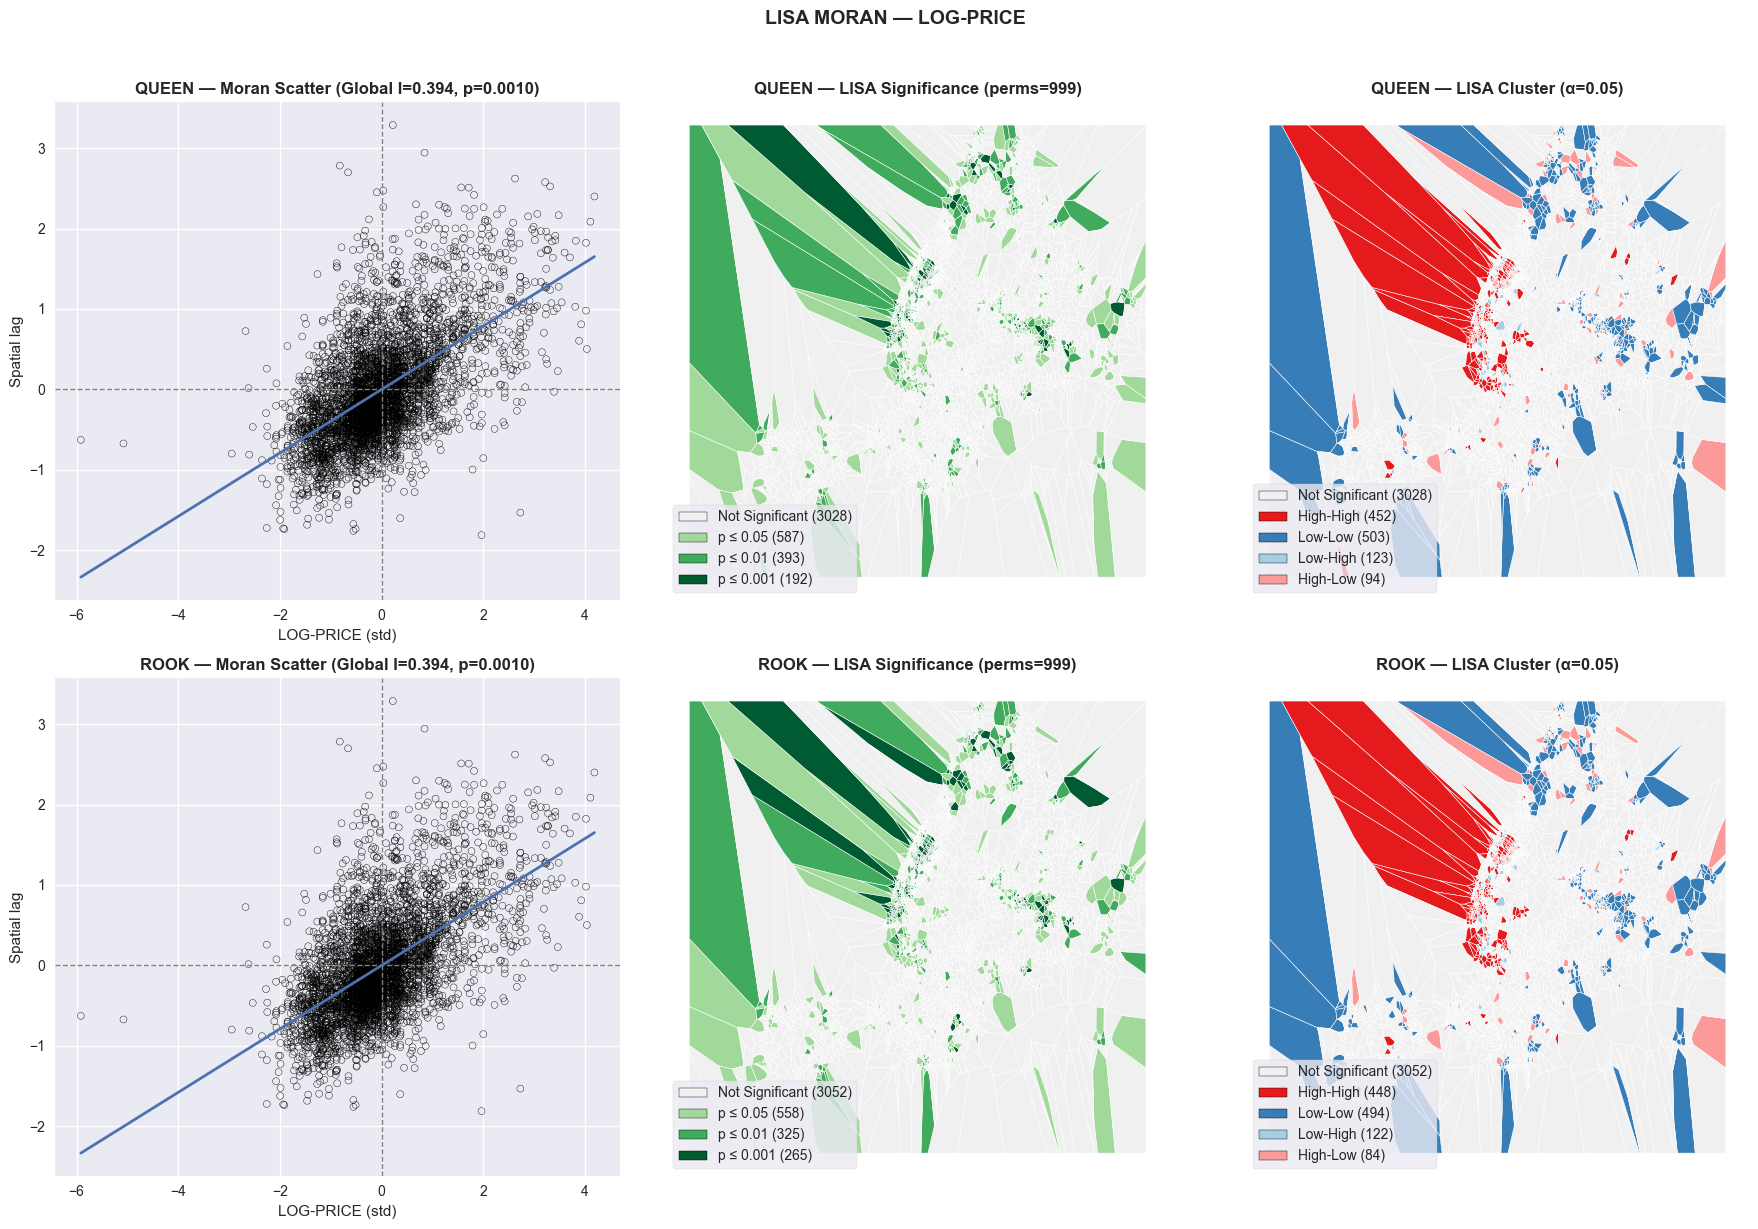

In [ ]:
# Inputs 
fields = ["LOG-PRICE","LOG-PROPER","BATH"]

table, fig, out = local_moran(
    gdf,
    fields,
    permutations=999,
    contiguities=("queen", "rook"),
    alpha=0.05,
    dashboard_field="LOG-PRICE",
)

# Outputs
display(table)
plt.show()

---